In [1]:
import pandas
import pandas as pd
import numpy as np
import pretty_midi
from torch.ao.nn.quantized.functional import clamp
from tqdm import tqdm
import os

In [2]:
def piano_roll_to_midi(piano_roll, fs=5, output_path='output.mid'):
    """
    Convierte un piano roll a un archivo MIDI.
    """
    midi_data = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Instrumento piano

    # Para cada nota en el rango del piano (88 notas)
    for note_index in range(piano_roll.shape[0]):
        # Encontrar los intervalos donde la nota está activa
        note_events = np.where(piano_roll[note_index, :] > 0)[0]

        if len(note_events) == 0:
            continue

        # Agrupar las activaciones de notas en eventos de nota continua
        current_note_start = note_events[0]
        for i in range(1, len(note_events)):
            if note_events[i] != note_events[i - 1] + 1:
                # Finalizar la nota anterior y comenzar una nueva
                note = pretty_midi.Note(
                    velocity=int(piano_roll[note_index, current_note_start] * 127),
                    pitch=note_index + 21,  # 21 es A0
                    start=current_note_start / fs,
                    end=note_events[i - 1] / fs
                )
                instrument.notes.append(note)
                current_note_start = note_events[i]

        # Añadir la última nota
        note = pretty_midi.Note(
            velocity=int(piano_roll[note_index, current_note_start] * 127),
            pitch=note_index + 21,  # 21 es A0
            start=current_note_start / fs,
            end=note_events[-1] / fs
        )
        instrument.notes.append(note)

    midi_data.instruments.append(instrument)
    midi_data.write(output_path)
    print(f"Archivo MIDI guardado en {output_path}")

In [3]:
# Cargar el dataset generado
dataset = np.load('maestro-v3.0.0/pre_processed_ds/maestro_var_dataset_2004.npz')
piano_rolls = dataset['piano_rolls']
metadata_features = dataset['metadata_features']

# Tomar la primera muestra
first_sample = piano_rolls[0]

print(first_sample.shape)

# Convertir la primera muestra de piano roll a MIDI
piano_roll_to_midi(first_sample, fs=5, output_path='output/first_sample_output.mid')

(88, 25)
Archivo MIDI guardado en output/first_sample_output.mid


In [4]:
# Reproducirlo, primero instalar timidity en el sistema
os.system("timidity output/first_sample_output.mid -Ow -o output/first_sample_output.wav")

Playing output/first_sample_output.mid
MIDI file: output/first_sample_output.mid
Format: 1  Tracks: 2  Divisions: 220
Playing time: ~7 seconds
Notes cut: 0
Notes lost totally: 0


0

In [34]:
from IPython.display import Audio

# Reproducir el archivo WAV
Audio('output/first_sample_output.wav')

# Generador

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc

In [7]:
# Configurar el dispositivo (GPU si está disponible, de lo contrario CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [8]:
# Función para cargar el dataset generado
def load_dataset(path):
    data = np.load(path)
    piano_rolls = data['piano_rolls']
    # El tamaño del piano_roll es (número de muestras, 88 * 5 * 5)
    piano_rolls = piano_rolls.reshape(piano_rolls.shape[0], -1)
    print(f"Forma del dataset: {piano_rolls.shape}")
    return torch.tensor(piano_rolls, dtype=torch.float32)

In [9]:
# Tamaño del lote
batch_size = 32

# Cargar el dataset
dataset_path = 'maestro-v3.0.0/pre_processed_ds/maestro_var_dataset_2004.npz'
piano_roll_data = load_dataset(dataset_path)

# Dividir en conjunto de entrenamiento y validación (80% entrenamiento, 20% validación)
train_size = int(0.8 * len(piano_roll_data))
val_size = len(piano_roll_data) - train_size
train_dataset, val_dataset = random_split(piano_roll_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Forma del dataset: (16765, 2200)


In [20]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim),
            nn.Sigmoid()  # Salida entre [0, 1]
        )

    def forward(self, z):
        return self.model(z)


# Definimos el Discriminador
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()  # Salida entre [0, 1], donde 1 es real y 0 es generado
        )

    def forward(self, x):
        return self.model(x)

Un pianista no puede tocar muchas notas al mismo tiempo, así que las penalizamos

In [21]:
def penalize_too_many_notes(fake_piano_rolls, max_notes=6):
    """
    Penaliza los piano rolls que tienen más de `max_notes` activadas simultáneamente.
    """
    # Contamos cuántas notas están activadas en cada segmento generado
    note_counts = (fake_piano_rolls > 0).sum(dim=1)  # Consideramos 0 como el umbral de "activado"

    # Penalizamos si hay más de `max_notes` activadas
    penalty = torch.relu(note_counts - max_notes).float().mean()
    return penalty

In [38]:
# Parámetros
latent_dim = 100  # Dimensión del vector de ruido
output_dim = 88 * 5 * 5  # 88 notas, 5 segundos, 5 muestras por segundo
input_dim = 88 * 5 * 5  # 88 notas, 5 segundos, 5 muestras por segundo
epochs = 100

In [39]:
# Inicializamos los modelos
generator = Generator(latent_dim, output_dim).to(device)
discriminator = Discriminator(input_dim).to(device)

# Función de pérdida (BCE = Binary Cross Entropy)
adversarial_loss = nn.BCELoss()

# Optimizadores
optimizer_G = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.5, 0.999))

# Listas para almacenar las métricas
g_losses = []
d_losses = []
penalties = []

for epoch in range(epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0
    epoch_penalty = 0

    for i, real_piano_rolls in enumerate(train_loader):
        # Entrenamiento del Discriminador
        optimizer_D.zero_grad()

        # Entradas reales y etiquetas (1 para reales)
        real_piano_rolls = real_piano_rolls.to(device)
        # real_labels = torch.ones((real_piano_rolls.size(0), 1), device=device)
        real_labels = torch.ones((real_piano_rolls.size(0), 1), device=device) * 0.9

        # Entradas falsas generadas por el Generador y etiquetas (0 para falsos)
        z = torch.randn((real_piano_rolls.size(0), latent_dim), device=device)
        fake_piano_rolls = generator(z)
        # fake_labels = torch.zeros((real_piano_rolls.size(0), 1), device=device)
        fake_labels = torch.zeros((real_piano_rolls.size(0), 1), device=device) + 0.1

        # Salida del discriminador para reales y falsos
        real_loss = adversarial_loss(discriminator(real_piano_rolls), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_piano_rolls.detach()), fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        epoch_d_loss += d_loss.item()

        # Entrenamiento del Generador
        optimizer_G.zero_grad()

        # Tratamos de "engañar" al discriminador, por lo que las etiquetas son 1
        gen_loss = adversarial_loss(discriminator(fake_piano_rolls), real_labels)

        # Penalización por demasiadas notas tocadas simultáneamente
        note_penalty = penalize_too_many_notes(fake_piano_rolls, max_notes=10)

        # La pérdida total es la pérdida adversarial + un factor de penalización
        total_loss = gen_loss + 0.5 * note_penalty

        total_loss.backward()
        optimizer_G.step()

        epoch_g_loss += gen_loss.item()
        epoch_penalty += note_penalty.item()

    # Almacenar pérdidas por epoch
    g_losses.append(epoch_g_loss / len(train_loader))
    d_losses.append(epoch_d_loss / len(train_loader))
    penalties.append(epoch_penalty / len(train_loader))

    print(
        f"Epoch [{epoch + 1}/{epochs}] | D Loss: {d_losses[-1]:.4f} | G Loss: {g_losses[-1]:.4f} | Note Penalty: {penalties[-1]:.4f}")


Epoch [1/100] | D Loss: 0.6878 | G Loss: 0.7730 | Note Penalty: 264.5453
Epoch [2/100] | D Loss: 0.6563 | G Loss: 0.8684 | Note Penalty: 52.9499
Epoch [3/100] | D Loss: 0.7046 | G Loss: 0.6758 | Note Penalty: 33.0565
Epoch [4/100] | D Loss: 0.6975 | G Loss: 0.6815 | Note Penalty: 34.5472
Epoch [5/100] | D Loss: 0.6967 | G Loss: 0.6822 | Note Penalty: 24.8516
Epoch [6/100] | D Loss: 0.6956 | G Loss: 0.6849 | Note Penalty: 30.1167
Epoch [7/100] | D Loss: 0.6949 | G Loss: 0.6884 | Note Penalty: 34.0231
Epoch [8/100] | D Loss: 0.6947 | G Loss: 0.6885 | Note Penalty: 30.8702
Epoch [9/100] | D Loss: 0.6945 | G Loss: 0.6895 | Note Penalty: 30.4505
Epoch [10/100] | D Loss: 0.6935 | G Loss: 0.6918 | Note Penalty: 26.5100
Epoch [11/100] | D Loss: 0.6925 | G Loss: 0.6968 | Note Penalty: 27.1869
Epoch [12/100] | D Loss: 0.6951 | G Loss: 0.6904 | Note Penalty: 37.8832
Epoch [13/100] | D Loss: 0.6940 | G Loss: 0.6918 | Note Penalty: 31.4042
Epoch [14/100] | D Loss: 0.6938 | G Loss: 0.6928 | Note Pen

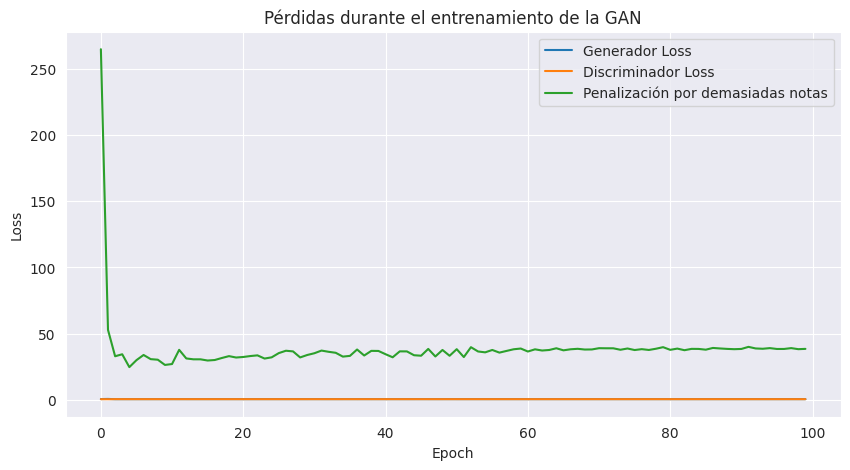

In [41]:
# Graficar las métricas
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generador Loss")
plt.plot(d_losses, label="Discriminador Loss")
plt.plot(penalties, label="Penalización por demasiadas notas")
plt.title("Pérdidas durante el entrenamiento de la GAN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [42]:
# Función para visualizar un piano roll
def visualize_piano_roll(piano_roll, title):
    plt.figure(figsize=(12, 4))
    plt.imshow(piano_roll.reshape(88, -1), aspect='auto', origin='lower')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('MIDI Note')
    plt.colorbar(label='Velocity')
    plt.show()


def piano_roll_to_midi(piano_roll, fs=5, output_path='output.mid'):
    """
    Convierte un piano roll a un archivo MIDI.
    """
    midi_data = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Instrumento piano

    # Para cada nota en el rango del piano (88 notas)
    for note_index in range(piano_roll.shape[0]):
        # Encontrar los intervalos donde la nota está activa
        note_events = np.where(piano_roll[note_index, :] > 0)[0]

        if len(note_events) == 0:
            continue

        # Agrupar las activaciones de notas en eventos de nota continua
        current_note_start = note_events[0]
        for i in range(1, len(note_events)):
            if note_events[i] != note_events[i - 1] + 1:
                # Finalizar la nota anterior y comenzar una nueva
                note = pretty_midi.Note(
                    velocity=int(piano_roll[note_index, current_note_start] * 127),
                    pitch=note_index + 21,  # 21 es A0
                    start=current_note_start / fs,
                    end=note_events[i - 1] / fs
                )
                instrument.notes.append(note)
                current_note_start = note_events[i]

        # Añadir la última nota
        note = pretty_midi.Note(
            velocity=int(piano_roll[note_index, current_note_start] * 127),
            pitch=note_index + 21,  # 21 es A0
            start=current_note_start / fs,
            end=note_events[-1] / fs
        )
        instrument.notes.append(note)

    midi_data.instruments.append(instrument)
    midi_data.write(output_path)
    print(f"Archivo MIDI guardado en {output_path}")




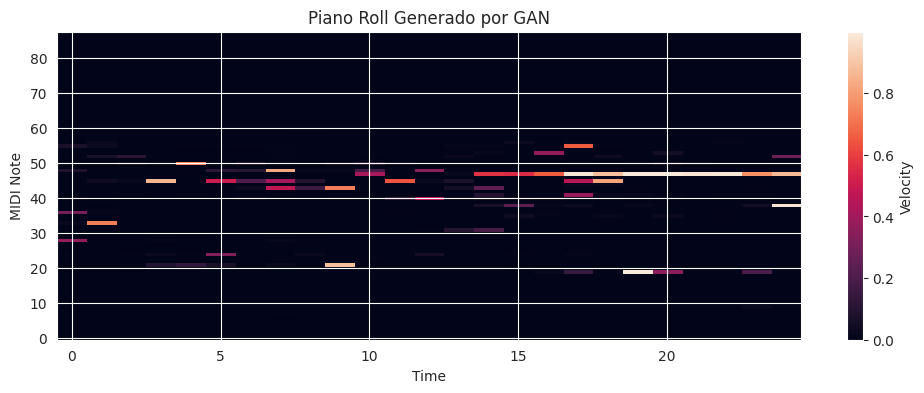

Archivo MIDI guardado en output/output_generated.midi


In [46]:
# Generar una muestra aleatoria de piano roll utilizando el generador
def generate_and_save_piano_roll(generator, latent_dim, output_file, fs=5):
    # Generamos ruido aleatorio para el generador
    z = torch.randn(1, latent_dim, device=device)

    # Generamos un piano roll con la GAN
    generator.eval()  # Cambiamos a modo de evaluación
    with torch.no_grad():
        generated_piano_roll = generator(z).cpu().numpy().reshape(88, -1)

    # Visualizar el piano roll generado
    visualize_piano_roll(generated_piano_roll, "Piano Roll Generado por GAN")

    # Guardar el piano roll como archivo MIDI
    piano_roll_to_midi(generated_piano_roll, fs=fs, output_path=output_file)

# Llamada a la función para generar y guardar música
generate_and_save_piano_roll(generator, latent_dim, 'output/output_generated.midi', fs=5)


In [47]:
audio_name = "output_generated"

# Reproducirlo, primero instalar timidity en el sistema
os.system(f"timidity output/{audio_name}.midi -Ow -o output/{audio_name}.wav")

# Reproducir el archivo WAV
Audio(f"output/{audio_name}.wav")

Playing output/output_generated.midi
MIDI file: output/output_generated.midi
Format: 1  Tracks: 2  Divisions: 220
Playing time: ~8 seconds
Notes cut: 0
Notes lost totally: 0


El problema es que el modelo genera notas que no tienen sentido musical, son las mismas notas los 5 segundos

In [55]:
def long_note_duration_penalty(fake_piano_rolls, max_duration=5):
    """
    Penaliza las notas que se mantienen activadas por más de `max_duration` frames consecutivos.
    """
    penalty = 0.0

    # Recorremos cada nota (88 en total) en el piano roll
    for note_index in range(fake_piano_rolls.shape[0]):
        note_activations = fake_piano_rolls[note_index, :] > 0  # Activa si es mayor que 0

        # Encontramos las longitudes de las secuencias de frames activados consecutivamente
        consecutive_frames = (note_activations[1:] != note_activations[:-1]).nonzero(as_tuple=True)[0] + 1
        durations = torch.diff(torch.cat([torch.tensor([0]).to(device), consecutive_frames, torch.tensor([note_activations.shape[0]]).to(device)]))

        # Penalizamos si alguna duración excede el máximo permitido
        long_durations = torch.relu(durations - max_duration).float().sum()
        penalty += long_durations

    return penalty / fake_piano_rolls.shape[1]  # Promedio de la penalización por frame

In [57]:
epochs = 200

# Inicializamos los modelos
generator = Generator(latent_dim, output_dim).to(device)
discriminator = Discriminator(input_dim).to(device)

# Función de pérdida (BCE = Binary Cross Entropy)
adversarial_loss = nn.BCELoss()

# Optimizadores
optimizer_G = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.5, 0.999))

# Listas para almacenar las métricas
g_losses = []
d_losses = []
note_penalties = []
diversity_penalties = []

for epoch in range(epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0
    epoch_note_penalty = 0
    diversity_note_penalty = 0

    for i, real_piano_rolls in enumerate(train_loader):
        # Entrenamiento del Discriminador
        optimizer_D.zero_grad()

        # Entradas reales y etiquetas (1 para reales)
        real_piano_rolls = real_piano_rolls.to(device)
        # real_labels = torch.ones((real_piano_rolls.size(0), 1), device=device)
        real_labels = torch.ones((real_piano_rolls.size(0), 1), device=device) * 0.9

        # Entradas falsas generadas por el Generador y etiquetas (0 para falsos)
        z = torch.randn((real_piano_rolls.size(0), latent_dim), device=device)
        fake_piano_rolls = generator(z)
        # fake_labels = torch.zeros((real_piano_rolls.size(0), 1), device=device)
        fake_labels = torch.zeros((real_piano_rolls.size(0), 1), device=device) + 0.1

        # Salida del discriminador para reales y falsos
        real_loss = adversarial_loss(discriminator(real_piano_rolls), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_piano_rolls.detach()), fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        epoch_d_loss += d_loss.item()

        # Entrenamiento del Generador
        optimizer_G.zero_grad()

        # Tratamos de "engañar" al discriminador, por lo que las etiquetas son 1
        gen_loss = adversarial_loss(discriminator(fake_piano_rolls), real_labels)

        # Penalización por demasiadas notas tocadas simultáneamente, o notas monotomas
        note_penalty = penalize_too_many_notes(fake_piano_rolls, max_notes=10)
        # Penalización por falta de diversidad de notas
        diversity_penalty = long_note_duration_penalty(fake_piano_rolls, max_duration=4)        

        # La pérdida total es la pérdida adversarial + un factor de penalización
        total_loss = gen_loss + 0.5 * note_penalty + 0.5 * diversity_penalty

        total_loss.backward()
        optimizer_G.step()

        epoch_g_loss += gen_loss.item()
        epoch_note_penalty += note_penalty.item()
        diversity_note_penalty += diversity_penalty.item()

    # Almacenar pérdidas por epoch
    g_losses.append(epoch_g_loss / len(train_loader))
    d_losses.append(epoch_d_loss / len(train_loader))
    note_penalties.append(epoch_note_penalty / len(train_loader))
    diversity_penalties.append(diversity_note_penalty / len(train_loader))

    print(
        f"Epoch [{epoch + 1}/{epochs}] | D Loss: {d_losses[-1]:.4f} | G Loss: {g_losses[-1]:.4f} | Note Penalty: {note_penalties[-1]:.4f} | Diversity Penalty: {diversity_penalties[-1]:.4f}")


Epoch [1/200] | D Loss: 0.6771 | G Loss: 0.8343 | Note Penalty: 284.5443 | Diversity Penalty: 31.8753
Epoch [2/200] | D Loss: 0.5575 | G Loss: 1.4926 | Note Penalty: 180.4420 | Diversity Penalty: 31.8643
Epoch [3/200] | D Loss: 0.5111 | G Loss: 1.6384 | Note Penalty: 188.2929 | Diversity Penalty: 30.3540
Epoch [4/200] | D Loss: 0.4489 | G Loss: 1.6576 | Note Penalty: 76.6509 | Diversity Penalty: 22.3727
Epoch [5/200] | D Loss: 0.3758 | G Loss: 2.0318 | Note Penalty: 135.0037 | Diversity Penalty: 8.4507
Epoch [6/200] | D Loss: 0.3371 | G Loss: 2.1121 | Note Penalty: 267.4743 | Diversity Penalty: 6.9904
Epoch [7/200] | D Loss: 0.3307 | G Loss: 2.0843 | Note Penalty: 436.1206 | Diversity Penalty: 6.2007
Epoch [8/200] | D Loss: 0.3292 | G Loss: 2.0884 | Note Penalty: 457.7255 | Diversity Penalty: 6.2912
Epoch [9/200] | D Loss: 0.3286 | G Loss: 2.0898 | Note Penalty: 494.8513 | Diversity Penalty: 6.4392
Epoch [10/200] | D Loss: 0.3372 | G Loss: 2.1328 | Note Penalty: 481.5843 | Diversity Pe

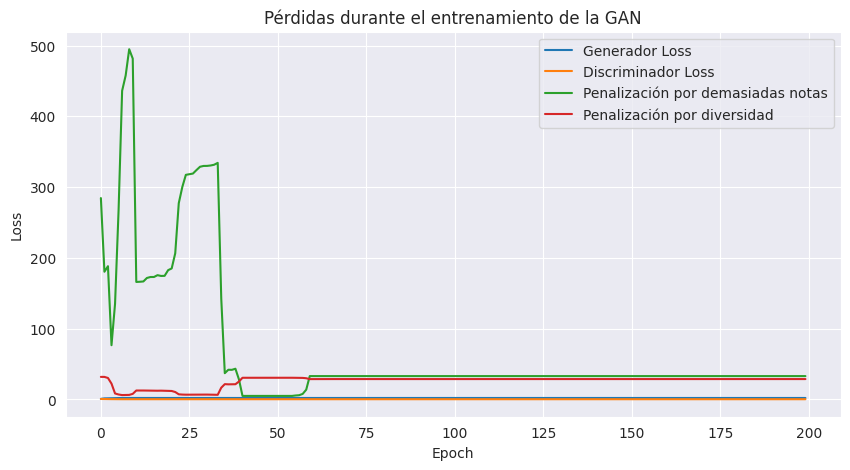

In [58]:
# Graficar las métricas
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generador Loss")
plt.plot(d_losses, label="Discriminador Loss")
plt.plot(note_penalties, label="Penalización por demasiadas notas")
plt.plot(diversity_penalties, label="Penalización por diversidad")
plt.title("Pérdidas durante el entrenamiento de la GAN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

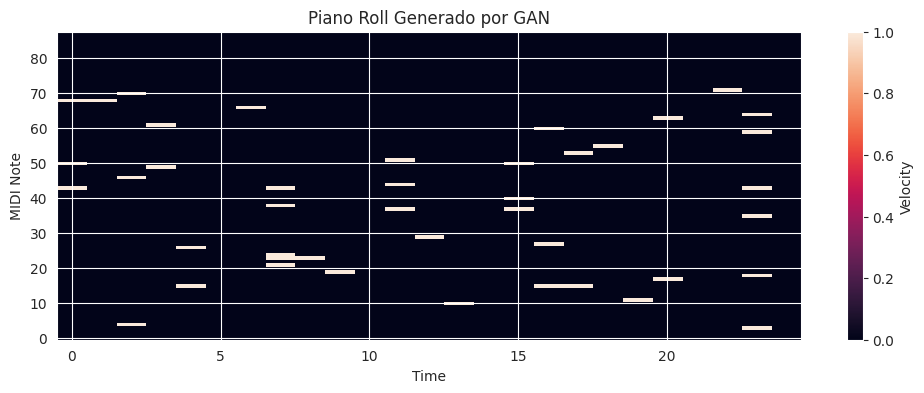

Archivo MIDI guardado en output/output_generated.midi


In [59]:
# Llamada a la función para generar y guardar música
generate_and_save_piano_roll(generator, latent_dim, 'output/output_generated.midi', fs=5)


In [60]:
audio_name = "output_generated"

# Reproducirlo, primero instalar timidity en el sistema
os.system(f"timidity output/{audio_name}.midi -Ow -o output/{audio_name}.wav")

# Reproducir el archivo WAV
Audio(f"output/{audio_name}.wav")

Playing output/output_generated.midi
MIDI file: output/output_generated.midi
Format: 1  Tracks: 2  Divisions: 220
Playing time: ~9 seconds
Notes cut: 0
Notes lost totally: 0


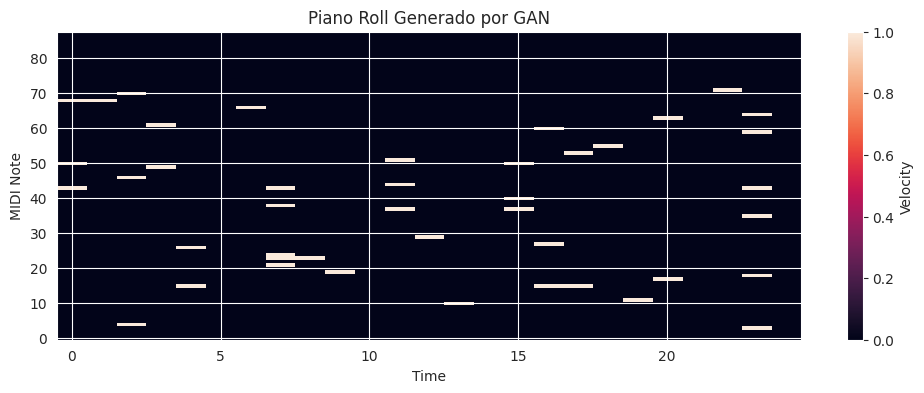

Archivo MIDI guardado en output/output_generated_2.midi


In [61]:
# Llamada a la función para generar y guardar música
generate_and_save_piano_roll(generator, latent_dim, 'output/output_generated_2.midi', fs=5)


In [62]:
audio_name = "output_generated_2"

# Reproducirlo, primero instalar timidity en el sistema
os.system(f"timidity output/{audio_name}.midi -Ow -o output/{audio_name}.wav")

# Reproducir el archivo WAV
Audio(f"output/{audio_name}.wav")

Playing output/output_generated_2.midi
MIDI file: output/output_generated_2.midi
Format: 1  Tracks: 2  Divisions: 220
Playing time: ~9 seconds
Notes cut: 0
Notes lost totally: 0


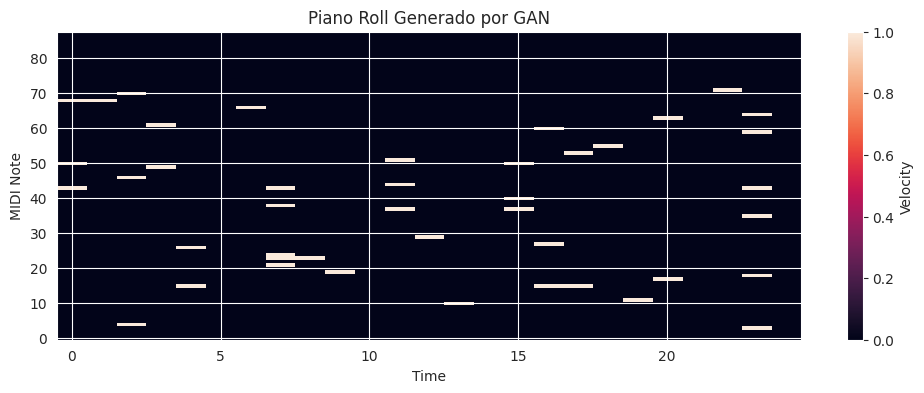

Archivo MIDI guardado en output/output_generated_3.midi


In [69]:
# Llamada a la función para generar y guardar música
generate_and_save_piano_roll(generator, latent_dim, 'output/output_generated_3.midi', fs=5)


In [70]:
audio_name = "output_generated_3"

# Reproducirlo, primero instalar timidity en el sistema
os.system(f"timidity output/{audio_name}.midi -Ow -o output/{audio_name}.wav")

# Reproducir el archivo WAV
Audio(f"output/{audio_name}.wav")

Playing output/output_generated_3.midi
MIDI file: output/output_generated_3.midi
Format: 1  Tracks: 2  Divisions: 220
Playing time: ~9 seconds
Notes cut: 0
Notes lost totally: 0
